In [1]:
import os
import pandas as pd
import numpy as np
import codecs
from collections import defaultdict

### Get Basic Frequency Information from results of CLAN's freqpos command

In [2]:
def get_wordcuts(wordcuts = 'PCDI_wordcuts_new.csv', conflict = False):
    pinyin_dict = defaultdict(list)
    conflict_list = []
    with codecs.open(wordcuts, 'r') as file:
        blocks = file.read().split('******')
        content = []
        for block in blocks:
            lines = block.strip().split('\n')
            if len(lines) > 1:
                for line in lines[1:]:
                    word, pinyin_list = line.split(',')
                    for pinyin in pinyin_list.strip().split(' '):
                        if pinyin in pinyin_dict.keys() and word not in pinyin_dict[pinyin]:
                            if conflict:
                                print("Conflict at {}".format(pinyin))
                                print("previous: {}, current: {}".format(pinyin_dict[pinyin], word))
                            conflict_list.append(pinyin)
                        pinyin_dict[pinyin].append(word)
                        
    return pinyin_dict, conflict_list

In [3]:
def get_lines(file_name, start_idx, end_idx):
    with codecs.open(file_name, 'r') as file:
        content = file.read().split('\n')
    lines = content[start_idx : end_idx]
    return lines

In [4]:
def extract_info(lines, py_dict):
    data = []
    for line in lines:
        line_split = line.split('    ')
        first_part = line_split[0].strip()
        last_part = line_split[-1].strip()
        total_count = int(first_part.split()[0])
        pinyin = first_part.split()[-1]
        word = py_dict[pinyin]
        counts = last_part.split(',')
        init_count = int(counts[0].split('=')[-1])
        final_count = int(counts[1].split('=')[-1])
        other_count = int(counts[2].split('=')[-1])
        iso_count = int(counts[3].split('=')[-1])
        data.append([pinyin, word, total_count, init_count, final_count, iso_count, other_count])
    return data

In [5]:
def get_table(file_name, py_dict, columns=['pinyin', 'word', 'total', 'init', 'final', 'iso', 'other']):
    lines = get_lines(file_name, 78, -6)
    res = extract_info(lines, py_dict)
    df = pd.DataFrame(data=res, columns=columns)
    df = df.sort_values(by = 'total', ascending = False)
    return df

In [6]:
py_dict, cf_list = get_wordcuts()
df_nouns = get_table(file_name= 'freqpos@PCDI_nouns_full.cex', py_dict=py_dict)
df_nouns.to_excel('freq_nouns.xlsx')
df_nouns.head()

,pinyin,word,total,init,final,iso,other
274,yao4,"[要, 药]",1598,372,210,35,981
28,che1,[车],1371,97,540,52,682
142,ma1ma,[妈妈],1295,457,119,191,528
91,hua4,[画],1199,205,306,12,676
0,a1yi2,[阿姨],1169,331,138,74,626


In [7]:
df_verbs = get_table(file_name= 'freqpos@PCDI_verbs_full.cex', py_dict=py_dict)
df_verbs.to_excel('freq_verbs.xlsx')
df_verbs.head()

,pinyin,word,total,init,final,iso,other
124,shi4,"[是, 试]",4796,780,418,58,3540
54,gei3,[给],2902,652,74,105,2071
171,you3,[有],2571,321,585,72,1593
88,lai2,[来],2483,672,611,294,906
20,chi1,[吃],2157,394,408,35,1320


### Get Repetition Count

In [8]:
def get_org_py(x):
    org_py = x[:(len(x)+1)//2]
    return org_py

In [9]:
def append_repetition_info(file_name, org_file_name, py_dict):
    df_double = get_table(file_name=file_name, py_dict=py_dict)
    df_double = df_double.drop(columns=['init', 'final', 'iso', 'other'])
    df_double['pinyin'] = df_double['pinyin'].apply(get_org_py)
    df_double.columns = ['pinyin', 'conflict_d', 'double']
    df_double = df_double.sort_values('pinyin')
    # df_nouns_double.head()
    
    df_double_grouped = pd.DataFrame(df_double.groupby('pinyin')['double'].sum())
    df_double_grouped['pinyin'] = df_double_grouped.index

    df_org = get_table(file_name= org_file_name, py_dict=py_dict)
    df_merged = pd.merge(left=df_org, right=df_double_grouped, how='left')
    df_conflict_d = df_double.drop(columns='double')

    df_merged = pd.merge(left=df_merged, right=df_conflict_d, how='left')
    df_merged = df_merged.drop_duplicates(subset= ['pinyin', 'total'])

    df_merged['double'] = df_merged['double'].fillna(0).astype(int)
    df_merged['conflict_d'] = df_merged['conflict_d'].fillna('[]')
    
    return df_merged.reset_index(drop=True)

In [10]:
df_noun_merged = append_repetition_info(file_name = 'freqpos@PCDI_nouns_full_double.cex', 
                                        org_file_name = 'freqpos@PCDI_nouns_full.cex',
                                        py_dict = py_dict)
df_noun_merged.head()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pinyin' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,pinyin,word,total,init,final,iso,other,double,conflict_d
0,yao4,"[要, 药]",1598,372,210,35,981,9,[]
1,che1,[车],1371,97,540,52,682,110,[]
2,ma1ma,[妈妈],1295,457,119,191,528,0,[]
3,hua4,[画],1199,205,306,12,676,15,[画画]
4,a1yi2,[阿姨],1169,331,138,74,626,0,[]


In [11]:
df_verb_merged = append_repetition_info(file_name = 'freqpos@PCDI_verbs_full_double.cex', 
                                        org_file_name = 'freqpos@PCDI_verbs_full.cex',
                                        py_dict = py_dict)
df_verb_merged.head()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pinyin' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,pinyin,word,total,init,final,iso,other,double,conflict_d
0,shi4,"[是, 试]",4796,780,418,58,3540,26,[]
1,gei3,[给],2902,652,74,105,2071,1,[]
2,you3,[有],2571,321,585,72,1593,0,[]
3,lai2,[来],2483,672,611,294,906,1,[]
4,chi1,[吃],2157,394,408,35,1320,7,[]


### Get Count on the Appearance with Markers

In [12]:
# following Ma, Zhou, et al. (2019)
v_before_markers = ['le', 'zhe']
v_after_markers = ['bu4', 'bu2', 'mei2', 'jiu4', 'hai2', 'zai4', 'doul', 'bie2', 'you4', 'ye3', 'neng2', 'xu3', 'dei3']
n_after_markers = ['de', 'ge', 'zhei4ge', 'yi2ge', 'nei4ge', 'nei3ge', 'nei4', 'zhe4', 'na4', 'dian3', 'dianr3']

In [13]:
nouns = list(pd.read_table('PCDI_nouns_full.cut', header=None)[0])
verbs = list(pd.read_table('PCDI_verbs_full.cut', header=None)[0])

In [14]:
def str_norm(string):
    res = string.strip()
    res = res.replace(':', '')
    res = res.replace('(', '')
    res = res.replace(')', '')
    res = res.replace('“', '')
    res = res.replace('”', '')
    return res

In [15]:
def split_list(some_list, unit):
    for i in range(0, len(some_list), unit):
        yield some_list[i:i+2]

In [16]:
def get_pairs(file_name, pair_unit=2):
    with codecs.open(file_name, 'r', encoding='utf-8') as file:
        lines = file.read().split('\r\n')
        for i in range(len(lines)-1):
            if (not lines[i+1].startswith('@')) and (not lines[i+1].startswith('*')):
                lines[i] += ' ' + lines[i+1][1:]
                # fixed bug here, as '\t' would be inserted when splited in two lines.
    records = [line.split('\t')[-1].strip() for line in lines if line.startswith('*')]
    norm_records = [str_norm(record).split() for record in records]
    # print(norm_records)
    results = []
    for record in norm_records:
        results.extend(split_list(record, pair_unit))
    return results

In [17]:
def get_marker_info(file_name, marker_list, marker_first):
    count_dict = defaultdict(int)
    set_dict = defaultdict(set)
    pairs = get_pairs(file_name)
    for pair in pairs:
        if marker_first:
            if pair[0] in marker_list:
                count_dict[pair[-1]] += 1
                set_dict[pair[-1]].add(pair[0])
        else:
            if pair[-1] in marker_list:
                count_dict[pair[0]] += 1
                set_dict[pair[0]].add(pair[-1])
    # print(pairs[0])
    return count_dict, set_dict

In [18]:
m_n_count, m_n_set = get_marker_info('PCDI_marker_noun.cex', n_after_markers, True)
m_v_count, m_v_set = get_marker_info('PCDI_marker_verb.cex', v_after_markers, True)
v_m_count, v_m_set = get_marker_info('PCDI_verb_marker.cex', v_before_markers, False)

In [19]:
df_nouns = pd.DataFrame(m_n_count, index=['marker_before']).transpose()
df_nouns['pinyin'] = df_nouns.index
df_nouns['marker_after'] = 0
df_nouns['marker_total'] = df_nouns['marker_before'] + df_nouns['marker_after']
df_m_v = pd.DataFrame(m_v_count, index=['marker_before']).transpose()
df_m_v['pinyin'] = df_m_v.index
df_v_m = pd.DataFrame(v_m_count, index=['marker_after']).transpose()
df_v_m['pinyin'] = df_v_m.index
df_verbs = pd.merge(df_v_m, df_m_v, 'left')
df_verbs['marker_before'] = df_verbs['marker_before'].fillna(0).astype(int)
df_verbs['marker_total'] = df_verbs['marker_before'] + df_verbs['marker_after']

In [20]:
df_noun_merged = pd.merge(df_noun_merged, df_nouns, 'left')
for col in ['marker_before', 'marker_after', 'marker_total']:
    df_noun_merged[col] = df_noun_merged[col].fillna(0).astype(int)
df_noun_merged.to_excel('freq_noun_merged.xlsx')
df_noun_merged.head()

,pinyin,word,total,init,final,iso,other,double,conflict_d,marker_before,marker_after,marker_total
0,yao4,"[要, 药]",1598,372,210,35,981,9,[],27,0,27
1,che1,[车],1371,97,540,52,682,110,[],159,0,159
2,ma1ma,[妈妈],1295,457,119,191,528,0,[],16,0,16
3,hua4,[画],1199,205,306,12,676,15,[画画],45,0,45
4,a1yi2,[阿姨],1169,331,138,74,626,0,[],49,0,49


In [21]:
df_noun_merged['p_init'] = df_noun_merged['init']/df_noun_merged['total']
df_noun_merged['p_final'] = df_noun_merged['final']/df_noun_merged['total']
df_noun_merged['p_iso'] = df_noun_merged['iso']/df_noun_merged['total']
df_noun_merged['p_repl'] = df_noun_merged['double']/df_noun_merged['total']
df_noun_merged['p_marker'] = df_noun_merged['marker_total']/df_noun_merged['total']
df_noun_merged['p_m_after'] = df_noun_merged['marker_after']/df_noun_merged['marker_total']
df_noun_merged['p_m_before'] = df_noun_merged['marker_before']/df_noun_merged['marker_total']
df_noun_merged.head()

,pinyin,word,total,init,final,iso,other,double,conflict_d,marker_before,marker_after,marker_total,p_init,p_final,p_iso,p_repl,p_marker,p_m_after,p_m_before
0,yao4,"[要, 药]",1598,372,210,35,981,9,[],27,0,27,0.232791,0.131414,0.021902,0.005632,0.016896,0.0,1.0
1,che1,[车],1371,97,540,52,682,110,[],159,0,159,0.070751,0.393873,0.037929,0.080233,0.115974,0.0,1.0
2,ma1ma,[妈妈],1295,457,119,191,528,0,[],16,0,16,0.352896,0.091892,0.147490,0.000000,0.012355,0.0,1.0
3,hua4,[画],1199,205,306,12,676,15,[画画],45,0,45,0.170976,0.255213,0.010008,0.012510,0.037531,0.0,1.0
4,a1yi2,[阿姨],1169,331,138,74,626,0,[],49,0,49,0.283148,0.118050,0.063302,0.000000,0.041916,0.0,1.0


In [22]:
df_verb_merged = pd.merge(df_verb_merged, df_verbs, 'left')
for col in ['marker_before', 'marker_after', 'marker_total']:
    df_verb_merged[col] = df_verb_merged[col].fillna(0).astype(int)
df_verb_merged.to_excel('freq_verb_merged.xlsx')
df_verb_merged.head()

,pinyin,word,total,init,final,iso,other,double,conflict_d,marker_after,marker_before,marker_total
0,shi4,"[是, 试]",4796,780,418,58,3540,26,[],7,1129,1136
1,gei3,[给],2902,652,74,105,2071,1,[],9,307,316
2,you3,[有],2571,321,585,72,1593,0,[],100,1274,1374
3,lai2,[来],2483,672,611,294,906,1,[],295,157,452
4,chi1,[吃],2157,394,408,35,1320,7,[],136,464,600


In [23]:
df_verb_merged['p_init'] = df_verb_merged['init']/df_verb_merged['total']
df_verb_merged['p_final'] = df_verb_merged['final']/df_verb_merged['total']
df_verb_merged['p_iso'] = df_verb_merged['iso']/df_verb_merged['total']
df_verb_merged['p_repl'] = df_verb_merged['double']/df_verb_merged['total']
df_verb_merged['p_marker'] = df_verb_merged['marker_total']/df_verb_merged['total']
df_verb_merged['p_m_after'] = df_verb_merged['marker_after']/df_verb_merged['marker_total']
df_verb_merged['p_m_before'] = df_verb_merged['marker_before']/df_verb_merged['marker_total']
df_verb_merged.head()

,pinyin,word,total,init,final,iso,other,double,conflict_d,marker_after,marker_before,marker_total,p_init,p_final,p_iso,p_repl,p_marker,p_m_after,p_m_before
0,shi4,"[是, 试]",4796,780,418,58,3540,26,[],7,1129,1136,0.162636,0.087156,0.012093,0.005421,0.236864,0.006162,0.993838
1,gei3,[给],2902,652,74,105,2071,1,[],9,307,316,0.224673,0.025500,0.036182,0.000345,0.108890,0.028481,0.971519
2,you3,[有],2571,321,585,72,1593,0,[],100,1274,1374,0.124854,0.227538,0.028005,0.000000,0.534422,0.072780,0.927220
3,lai2,[来],2483,672,611,294,906,1,[],295,157,452,0.270640,0.246073,0.118405,0.000403,0.182038,0.652655,0.347345
4,chi1,[吃],2157,394,408,35,1320,7,[],136,464,600,0.182661,0.189152,0.016226,0.003245,0.278164,0.226667,0.773333


### Get Imageability and AoA Stage Info

In [24]:
result_files = os.listdir('rating_sheets/result')
AoA_files, img_files = [], []
for result_file in result_files:
    if result_file.startswith('AoA'):
        AoA_files.append(result_file)
    elif result_file.startswith('image'):
        img_files.append(result_file)
        
# print(AoA_files, img_files)

In [25]:
def get_vote(file_list, feature = 'AoA stage'):
    noun_dict = defaultdict(list)
    verb_dict = defaultdict(list)

    for file in file_list:
        df_nouns = pd.read_excel('rating_sheets/result/' + file, sheet_name=0)
        df_verbs = pd.read_excel('rating_sheets/result/' + file, sheet_name=1)
        
        if df_nouns[feature].hasnans or df_verbs[feature].hasnans:
            print(file, "has nans!")
            continue
            
        idx_nouns = df_nouns.index.values
        value_nouns = df_nouns[feature].values
        
        for i in range(len(idx_nouns)):
            noun_dict[idx_nouns[i]].append(value_nouns[i])
            
        idx_verbs = df_verbs.index.values
        value_verbs = df_verbs[feature].values
        
        for i in range(len(idx_verbs)):
            verb_dict[idx_verbs[i]].append(value_verbs[i])
    
    for i in range(len(idx_verbs)):
        verb_dict[idx_verbs[i]].append(np.argmax(np.bincount(verb_dict[idx_verbs[i]])))
        verb_dict[idx_verbs[i]].append(((np.bincount(verb_dict[idx_verbs[i]]))!=0).sum())
    
    for i in range(len(idx_nouns)):
        noun_dict[idx_nouns[i]].append(np.argmax(np.bincount(noun_dict[idx_nouns[i]])))
        noun_dict[idx_nouns[i]].append(((np.bincount(noun_dict[idx_nouns[i]]))!=0).sum())
        
    df_noun = pd.DataFrame(noun_dict).transpose()
    df_noun.rename(columns = {20: 'result'}, inplace=True)
    df_noun.rename(columns = {21: 't_score'}, inplace=True)
    
    df_verb = pd.DataFrame(verb_dict).transpose()
    df_verb.rename(columns = {20: 'result'}, inplace=True)
    df_verb.rename(columns = {21: 't_score'}, inplace=True)
    
    return df_noun, df_verb

In [26]:
def get_mean(file_list, normalize=False):
    total_nouns = pd.DataFrame()
    total_verbs = pd.DataFrame()
    for file in file_list:
        df_nouns = pd.read_excel('rating_sheets/result/' + file, sheet_name=0)
        df_verbs = pd.read_excel('rating_sheets/result/' + file, sheet_name=1)
        
        # conduct z-score normalization for nouns and verbs respectively
        if normalize:
            feature_name = df_nouns.columns[2]
            df_nouns[feature_name] = (df_nouns[feature_name] - df_nouns[feature_name].mean()) / df_nouns[feature_name].std()
            df_verbs[feature_name] = (df_verbs[feature_name] - df_verbs[feature_name].mean()) / df_verbs[feature_name].std()

        total_nouns = pd.concat([total_nouns, df_nouns])
        total_verbs = pd.concat([total_verbs, df_verbs])

    total_nouns_mean = total_nouns.groupby(total_nouns.index, sort=True).mean()
    total_verbs_mean = total_verbs.groupby(total_verbs.index, sort=True).mean()    
    return total_nouns_mean, total_verbs_mean

In [27]:
img_nouns_mean_normal, img_verbs_mean_normal = get_mean(img_files, True)
# For the task of AoA stage prediction, it is nessessary to normalize imageability scores, 
# as participants may have personal criterion for such rating with a seven-scale.

img_nouns_mean_no_normal, img_verbs_mean_no_normal = get_mean(img_files, False)
# For the task of noun-verb identification, it is not nessessary to normalize the scores,
# as inter-class difference exists

aoa_nouns_mean, aoa_verbs_mean = get_mean(AoA_files, False)
# However, it is NOT nessessary for AoA data, since participants 
# were informed to EVENLY group the words into three stages.

aoa_nouns_vote, aoa_verbs_vote = get_vote(AoA_files)
# Using vote to better group the AoA stage data of the target words,
# however, this makes the dataset somwhow unbalanced. 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [28]:
img_nouns_mean_no_normal.rename(columns={'imageability':'img_mean'}, inplace=True)
img_nouns_mean_normal.rename(columns={'imageability':'img_norm'}, inplace=True)
img_nouns_mean = img_nouns_mean_no_normal.join(img_nouns_mean_normal)
img_nouns_mean.head()

,img_mean,img_norm
1,5.30,-0.106328
2,5.75,0.211130
3,4.95,-0.368324
4,4.25,-0.966122
5,5.60,0.114581


In [29]:
img_verbs_mean_no_normal.rename(columns={'imageability':'img_mean'}, inplace=True)
img_verbs_mean_normal.rename(columns={'imageability':'img_norm'}, inplace=True)
img_verbs_mean = img_verbs_mean_no_normal.join(img_verbs_mean_normal)
img_verbs_mean.head()

,img_mean,img_norm
0,2.95,-1.221235
1,3.95,-0.486876
2,2.25,-1.708078
3,3.55,-0.813048
4,5.75,0.643266


In [30]:
print("=====AoA Quantiles for Nouns=====")
print(aoa_nouns_mean.quantile(q=1/3))
print(aoa_nouns_mean.quantile(q=2/3))

print()

print("=====AoA Quantiles for Verbs=====")
print(aoa_verbs_mean.quantile(q=1/3))
print(aoa_verbs_mean.quantile(q=2/3))

=====AoA Quantiles for Nouns=====
AoA stage    1.55
Name: 0.3333333333333333, dtype: float64
AoA stage    2.05
Name: 0.6666666666666666, dtype: float64

=====AoA Quantiles for Verbs=====
AoA stage    1.65
Name: 0.3333333333333333, dtype: float64
AoA stage    2.15
Name: 0.6666666666666666, dtype: float64


In [31]:
def aoa_noun_trans(x):
    if x <= aoa_nouns_mean.quantile(q=1/3)[0]:
        return 1
    elif x <= aoa_nouns_mean.quantile(q=2/3)[0]:
        return 2
    else:
        return 3
    
def aoa_verb_trans(x):
    if x <= aoa_verbs_mean.quantile(q=1/3)[0]:
        return 1
    elif x <= aoa_verbs_mean.quantile(q=2/3)[0]:
        return 2
    else:
        return 3

In [32]:
aoa_nouns_mean['AoA class'] = aoa_nouns_mean['AoA stage'].apply(aoa_noun_trans)
aoa_nouns_merged = aoa_nouns_mean.join(aoa_nouns_vote['result'])
aoa_nouns_merged.rename(columns={'result':'AoA vote'}, inplace=True)
aoa_nouns_merged.head()

,AoA stage,AoA class,AoA vote
1,1.25,1,1
2,1.05,1,1
3,1.75,2,1
4,1.35,1,1
5,1.05,1,1


In [33]:
aoa_verbs_mean['AoA class'] = aoa_verbs_mean['AoA stage'].apply(aoa_verb_trans)
aoa_verbs_merged = aoa_verbs_mean.join(aoa_verbs_vote['result'])
aoa_verbs_merged.rename(columns={'result':'AoA vote'}, inplace=True)
aoa_verbs_merged

,AoA stage,AoA class,AoA vote
0,1.55,1,2
1,1.25,1,1
2,1.30,1,1
3,1.30,1,1
4,1.05,1,1
5,1.25,1,1
6,1.05,1,1
7,1.25,1,1
8,1.25,1,1
9,1.15,1,1


In [34]:
df_noun_whole = df_noun_merged.join(img_nouns_mean, how='right').join(aoa_nouns_merged)
df_noun_whole['class'] = 0
# 0 for noun, 1 for verb
df_noun_whole.head()

,pinyin,word,total,init,final,iso,other,double,conflict_d,marker_before,...,p_repl,p_marker,p_m_after,p_m_before,img_mean,img_norm,AoA stage,AoA class,AoA vote,class
1,che1,[车],1371,97,540,52,682,110,[],159,...,0.080233,0.115974,0.0,1.0,5.30,-0.106328,1.25,1,1,0
2,ma1ma,[妈妈],1295,457,119,191,528,0,[],16,...,0.000000,0.012355,0.0,1.0,5.75,0.211130,1.05,1,1,0
3,hua4,[画],1199,205,306,12,676,15,[画画],45,...,0.012510,0.037531,0.0,1.0,4.95,-0.368324,1.75,2,1,0
4,a1yi2,[阿姨],1169,331,138,74,626,0,[],49,...,0.000000,0.041916,0.0,1.0,4.25,-0.966122,1.35,1,1,0
5,ba4ba,[爸爸],601,165,68,103,265,0,[],13,...,0.000000,0.021631,0.0,1.0,5.60,0.114581,1.05,1,1,0


In [35]:
df_verb_whole = df_verb_merged.join(img_verbs_mean, how='right').join(aoa_verbs_merged)
df_verb_whole['class'] = 1
# 0 for noun, 1 for verb
df_verb_whole.head()

,pinyin,word,total,init,final,iso,other,double,conflict_d,marker_after,...,p_repl,p_marker,p_m_after,p_m_before,img_mean,img_norm,AoA stage,AoA class,AoA vote,class
0,shi4,"[是, 试]",4796,780,418,58,3540,26,[],7,...,0.005421,0.236864,0.006162,0.993838,2.95,-1.221235,1.55,1,2,1
1,gei3,[给],2902,652,74,105,2071,1,[],9,...,0.000345,0.108890,0.028481,0.971519,3.95,-0.486876,1.25,1,1,1
2,you3,[有],2571,321,585,72,1593,0,[],100,...,0.000000,0.534422,0.072780,0.927220,2.25,-1.708078,1.30,1,1,1
3,lai2,[来],2483,672,611,294,906,1,[],295,...,0.000403,0.182038,0.652655,0.347345,3.55,-0.813048,1.30,1,1,1
4,chi1,[吃],2157,394,408,35,1320,7,[],136,...,0.003245,0.278164,0.226667,0.773333,5.75,0.643266,1.05,1,1,1


### Get the whole table for nouns and verbs
##### 0 for nouns, 1 for verbs

In [36]:
df_whole = pd.concat([df_noun_whole, df_verb_whole], axis=0, ignore_index=True, sort=False)
df_whole = df_whole.drop(columns=['p_m_after', 'p_m_before'])
# These two features has nan values, as words could have no marker co-appearance.
df_whole

,pinyin,word,total,init,final,iso,other,double,conflict_d,marker_before,...,p_final,p_iso,p_repl,p_marker,img_mean,img_norm,AoA stage,AoA class,AoA vote,class
0,che1,[车],1371,97,540,52,682,110,[],159,...,0.393873,0.037929,0.080233,0.115974,5.30,-0.106328,1.25,1,1,0
1,ma1ma,[妈妈],1295,457,119,191,528,0,[],16,...,0.091892,0.147490,0.000000,0.012355,5.75,0.211130,1.05,1,1,0
2,hua4,[画],1199,205,306,12,676,15,[画画],45,...,0.255213,0.010008,0.012510,0.037531,4.95,-0.368324,1.75,2,1,0
3,a1yi2,[阿姨],1169,331,138,74,626,0,[],49,...,0.118050,0.063302,0.000000,0.041916,4.25,-0.966122,1.35,1,1,0
4,ba4ba,[爸爸],601,165,68,103,265,0,[],13,...,0.113145,0.171381,0.000000,0.021631,5.60,0.114581,1.05,1,1,0
5,jia1,"[夹, 家]",488,27,91,14,356,41,[],3,...,0.186475,0.028689,0.084016,0.006148,4.15,-1.020191,1.30,1,1,0
6,ge1,"[搁, 歌]",470,154,69,11,236,226,[哥哥],24,...,0.146809,0.023404,0.480851,0.051064,4.05,-1.167638,1.70,2,1,0
7,shou3,[手],462,36,136,11,279,3,[],47,...,0.294372,0.023810,0.006494,0.101732,6.40,0.675727,1.05,1,1,0
8,fan4,[饭],414,11,97,2,304,30,[],11,...,0.234300,0.004831,0.072464,0.026570,5.30,-0.123882,1.05,1,1,0
9,bao3bao,[宝宝],365,137,75,50,103,0,[],16,...,0.205479,0.136986,0.000000,0.043836,4.95,-0.459381,1.15,1,1,0


In [37]:
df_whole.describe()

,total,init,final,iso,other,double,marker_before,marker_after,marker_total,p_init,p_final,p_iso,p_repl,p_marker,img_mean,img_norm,AoA stage,AoA class,AoA vote,class
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,3.470000e+02,347.000000,347.000000,347.000000,347.000000
mean,196.440922,38.345821,36.930836,11.634006,109.530259,10.596542,27.340058,9.939481,37.279539,0.175212,0.235566,0.086587,0.101227,0.153809,5.168300,2.879541e-17,1.877233,1.988473,1.806916,0.466859
std,453.452299,91.670125,80.833060,35.640486,290.040950,38.618316,104.090360,30.260417,118.122620,0.116473,0.134639,0.104038,0.592175,0.163641,0.951195,6.436375e-01,0.489810,0.811681,0.745048,0.499621
min,10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.850000,-3.179301e+00,1.050000,1.000000,1.000000,0.000000
25%,24.000000,3.000000,5.000000,1.000000,10.000000,0.000000,1.000000,0.000000,1.000000,0.084932,0.135852,0.018645,0.000000,0.033808,4.700000,-3.473092e-01,1.500000,1.000000,1.000000,0.000000
50%,54.000000,9.000000,12.000000,4.000000,27.000000,0.000000,5.000000,0.000000,6.000000,0.161290,0.217544,0.052632,0.000000,0.100000,5.400000,1.602493e-01,1.850000,2.000000,2.000000,0.000000
75%,156.000000,27.000000,30.000000,9.000000,81.000000,5.000000,14.000000,5.000000,23.000000,0.250000,0.315421,0.117382,0.048467,0.209934,5.850000,4.397417e-01,2.250000,3.000000,2.000000,1.000000
max,4796.000000,780.000000,636.000000,489.000000,3540.000000,477.000000,1274.000000,295.000000,1374.000000,0.645161,0.769231,0.615385,10.300000,0.823843,6.550000,1.060064e+00,3.000000,3.000000,3.000000,1.000000


In [40]:
# df_whole.describe().transpose().to_csv('feature_info.csv')
df_whole.to_csv('data.csv', encoding='gbk')

In [39]:
df_whole.skew(axis = 0, skipna = True) 

total             5.461058
init              4.714516
final             4.952922
iso               9.252792
other             6.969564
double            7.756752
marker_before     9.138767
marker_after      5.717159
marker_total      7.556369
p_init            0.698123
p_final           0.830048
p_iso             2.325300
p_repl           15.256955
p_marker          1.531459
img_mean         -1.195597
img_norm         -1.379701
AoA stage         0.200846
AoA class         0.021112
AoA vote          0.328602
class             0.133435
dtype: float64

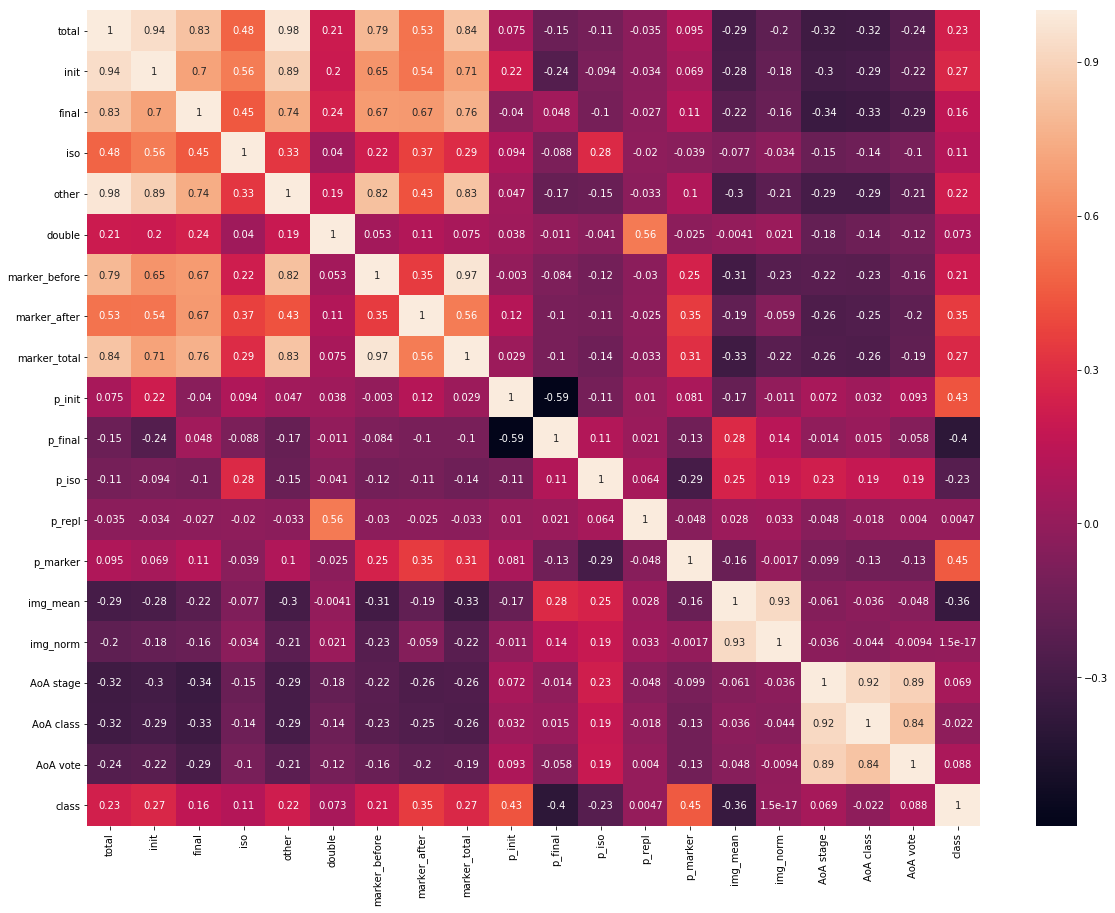

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df_whole.corr()
f, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(corr, annot=True)

In [66]:
def draw_dist_nv(df, feature, bins=10):
    sns.distplot(df[df['class'] == 0][feature], kde_kws={'label': 'noun'}, bins=bins)
    sns.distplot(df[df['class'] == 1][feature], kde_kws={'label': 'verb'}, bins=bins)
    # sns.distplot(df[feature], kde_kws={'label': 'all'}, bins=bins)

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


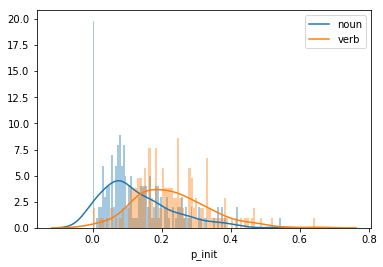

In [67]:
draw_dist_nv(df_whole, 'p_init', 100)

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


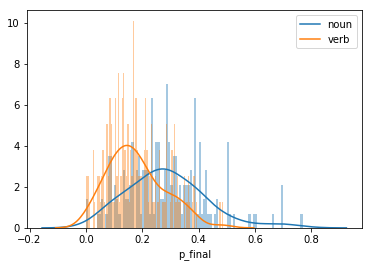

In [59]:
draw_dist_nv(df_whole, 'p_final', 100)

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


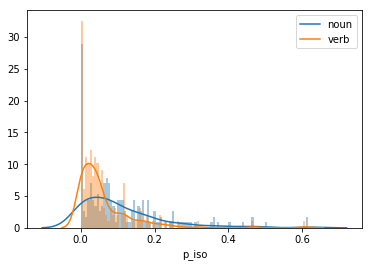

In [60]:
draw_dist_nv(df_whole, 'p_iso', 100)

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


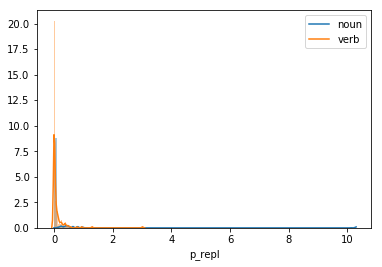

In [61]:
draw_dist_nv(df_whole, 'p_repl', 100)

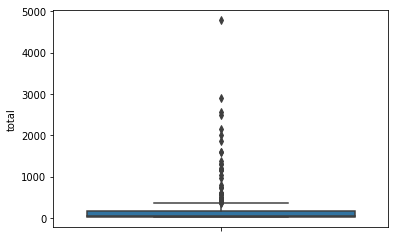

In [81]:
# fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(24,18))
# print(fig, axes)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
sns.boxplot(y='total', data=df_whole)